In [1]:
from __future__ import division
import os
import numpy as np
import pprint
import tensorflow as tf
import tensorflow.contrib.slim as slim
import pickle, csv
import sys
import time
import datetime
#import nilearn
import nibabel as nib
from scipy.ndimage.morphology import binary_dilation
sys.path.append('..')
from utils import *
from model import UNet3D
#
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# Project dir
proj_dir = '/Users/nikhil/code/git_repos/skull_seg/'

p = 32*32*32
v = 193*229*193
c = 400
p*c/v

1.5365964515210455

# Mask the images based on an average skull mask from all subjects

In [18]:
thrsh = 10
dil_iter = 8

skull_mask_file = proj_dir + 'sample_data/masks/skull_mask.nii'
skull_mask = nib.load(skull_mask_file).get_fdata()
print(skull_mask.shape)

skull_mask = skull_mask > thrsh

#Create dialated mask to ignore brain regions from skull areas
skull_mask_dil = binary_dilation(skull_mask,iterations=dil_iter).astype(int)
print(np.sum(skull_mask),np.sum(skull_mask_dil))

(193, 229, 193)
(496134, 2001435)


In [24]:
# Mask the subject image 
subject_dir = proj_dir + '/sample_data/input/sub05/'
subject_img_file = subject_dir + 't1w_05_img.nii.gz'
subject_img_nii = nib.load(subject_img_file)
subject_img = subject_img_nii.get_fdata()
masked_subject_img = np.multiply(skull_mask_dil,subject_img) 
print(masked_subject_img.shape)

# masked_subject_img_nii = nib.Nifti1Image(masked_subject_img, subject_img_nii.affine, subject_img_nii.header)
# nib.save(masked_subject_img_nii, subject_dir + 't1w_05_img_masked.nii.gz')

(193, 229, 193)


In [25]:
# Skull labels rounding errors (binarize explicitly)
subject_dir = proj_dir + '/sample_data/input/sub05/'
subject_seg_file = subject_dir + 't1w_05_seg_float.nii.gz'
subject_seg_nii = nib.load(subject_seg_file)
subject_seg = subject_seg_nii.get_fdata()
bin_subject_seg = subject_seg > 0.5

# bin_subject_seg_nii = nib.Nifti1Image(bin_subject_seg, subject_seg_nii.affine, subject_seg_nii.header)
# nib.save(bin_subject_seg_nii, subject_dir + 't1w_05_seg.nii.gz')


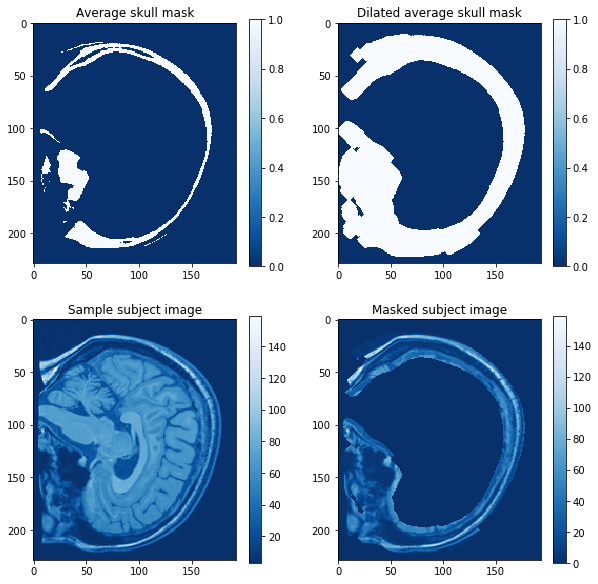

In [23]:
# Plots
s = 100
skull_mask_slice = skull_mask[s,:,:]
skull_mask_dil_slice = skull_mask_dil[s,:,:]
subject_img_slice = subject_img[s,:,:]
masked_subject_img_slice = masked_subject_img[s,:,:]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
seg_plot = plt.imshow(skull_mask_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Average skull mask')

plt.subplot(2,2,2)
seg_plot = plt.imshow(skull_mask_dil_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Dilated average skull mask')

plt.subplot(2,2,3)
seg_plot = plt.imshow(subject_img_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Sample subject image')

plt.subplot(2,2,4)
seg_plot = plt.imshow(masked_subject_img_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('Masked subject image')

In [34]:
# Check patched data
# Need to fix label values
skull_labels = []
for p in range(400):
    mr_patch= np.load(proj_dir + 'sample_data/patches/p64/sub05/{}.npy'.format(p))
    skull_labels.append(np.sum(mr_patch[:,:,:,1]))

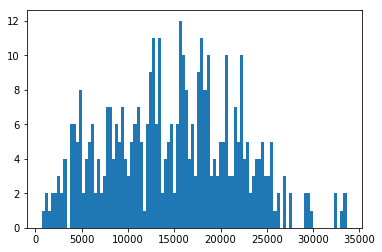

In [35]:
plt.hist(np.array(skull_labels).ravel(),bins=100);

In [36]:
# check segmented data
img = nib.load(proj_dir + 'sample_data/input/sub05/t1w_05_img.nii.gz').get_fdata()
img_masked = nib.load(proj_dir + 'sample_data/input/sub05/t1w_05_img_masked.nii.gz').get_fdata()
img_label = nib.load(proj_dir + 'sample_data/input/sub05/t1w_05_seg.nii.gz').get_fdata()
img_pred = np.load(proj_dir + 'sample_data/predictions/sub05_probs.npy')
img_label.shape, img_pred.shape

((193, 229, 193), (193, 229, 193, 2))

(array([ 7056272.,   256965.,   159461.,   543543.,   513780.,   513780.,
          543543.,   159461.,   256965.,  7056272.]),
 array([  5.93263427e-21,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

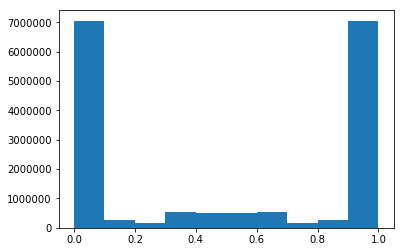

In [37]:
plt.hist(img_pred.ravel())

Acc 0.953997182422, dice 0.646760436593


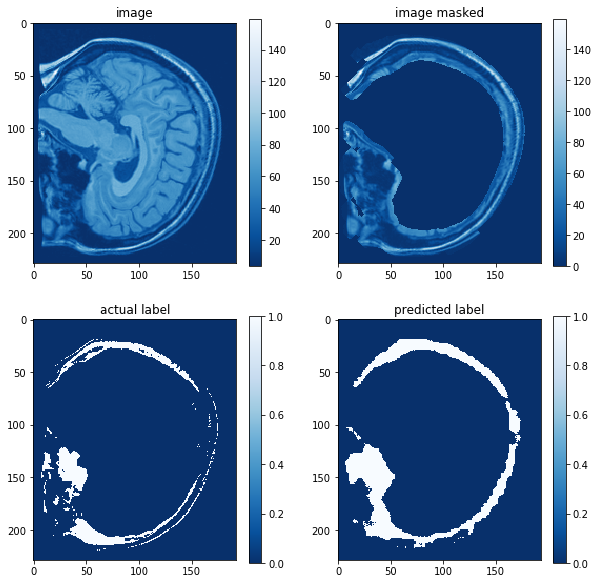

In [52]:
s = 100
thesh = 0.5
img_pred_label = img_pred[:,:,:,1]> thesh

acc = np.sum(img_label==img_pred_label)/len(img_label.ravel())
d = dice(img_label,img_pred_label)
print('Acc {}, dice {}'.format(acc,d))

img_slice = img[s,:,:]
img_masked_slice = img_masked[s,:,:]
img_label_slice = img_label[s,:,:]
img_pred_slice = img_pred_label[s,:,:]


plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
seg_plot = plt.imshow(img_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('image')

plt.subplot(2,2,2)
seg_plot = plt.imshow(img_masked_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('image masked')

plt.subplot(2,2,3)
seg_plot = plt.imshow(img_label_slice)
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('actual label')

plt.subplot(2,2,4)
seg_plot = plt.imshow(img_pred_slice.astype(int))
seg_plot.set_cmap("Blues_r")
plt.colorbar()
plt.title('predicted label')

In [45]:
"""
_dice.py : Dice coefficient for comparing set similarity.

"""

import numpy as np


def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.

    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.

    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.

    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())